In [1]:
import torch
from torch import nn

import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision import datasets

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from PIL import Image
import cv2

import os
import json

# 0. Device agnostic

In [2]:
print(torch.__version__)

2.3.1+cu118


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 1. Prepare the dataset

In [4]:
TRAIN_PATH = "data/aug_data/train"
TEST_PATH = "data/aug_data/test"
VAL_PATH = "data/aug_data/val"

## 1.1. Getting the train, test, val images (splitted and augmented)

In [5]:
import glob

train_images = glob.glob("data/aug_data/train/images/*.jpg")
test_images = glob.glob("data/aug_data/test/images/*.jpg")
val_images = glob.glob("data/aug_data/val/images/*.jpg")

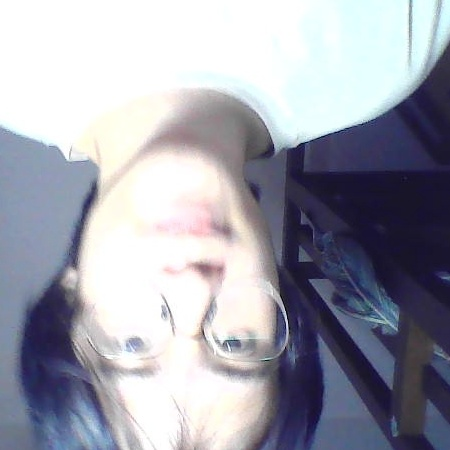

In [6]:
sample = Image.open(train_images[0])
sample

In [7]:
sample_tensor = ToTensor()(sample)
print(sample_tensor)
print(f"Tensor shape: {sample_tensor.shape}")

tensor([[[1.0000, 1.0000, 1.0000,  ..., 0.8588, 0.8471, 0.8510],
         [1.0000, 1.0000, 1.0000,  ..., 0.8392, 0.8471, 0.8431],
         [1.0000, 1.0000, 1.0000,  ..., 0.8471, 0.8471, 0.8549],
         ...,
         [0.4196, 0.4235, 0.4353,  ..., 0.2627, 0.2667, 0.2667],
         [0.4235, 0.4314, 0.4275,  ..., 0.2627, 0.2627, 0.2706],
         [0.4235, 0.4314, 0.4275,  ..., 0.2627, 0.2706, 0.2784]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 0.9804, 0.9882, 0.9961],
         [1.0000, 1.0000, 1.0000,  ..., 0.9882, 0.9882, 0.9961],
         ...,
         [0.4510, 0.4549, 0.4588,  ..., 0.3176, 0.3216, 0.3216],
         [0.4471, 0.4549, 0.4588,  ..., 0.3255, 0.3176, 0.3216],
         [0.4471, 0.4549, 0.4588,  ..., 0.3255, 0.3255, 0.3294]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.9961, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 0.9804, 0.9882, 0.9922],
         [1.0000, 1.0000, 1.0000,  ..., 0.9882, 0.9882, 0.

### 1.1.1. Transform the images

In [8]:
image_transform = transforms.Compose([
    transforms.Resize((120, 120)),
])

In [9]:
# Plot transformed image

def plot_transformed_image(image_path):
    image = Image.open(image_path)
    image_tensor = image_transform(image)
    plt.imshow(image_tensor.squeeze().permute(1, 2, 0))

    # Print metadata
    print("Original Image shape:", np.array(image).shape)
    print("Original Image type:", np.array(image).dtype)
    print("Transformed Image shape:", image_tensor.shape)
    print("Transformed Image type:", image_tensor.dtype)

    plt.axis("off")

plot_transformed_image(train_images[0])

AttributeError: 'Image' object has no attribute 'squeeze'

## 1.2. Retrieving labels

In [10]:
# Get coords
label_path = "data/aug_data/train/labels/8a6d3ee0-4344-11ef-87af-f854f63b872e.0.json"
with open(label_path, "r") as f:
    label = json.load(f)

label

coords = label['bbox']
coords = torch.tensor(coords).type(torch.float32)
coords

#coords = [0, 0, 0, 0]
#coords[0] = label['shapes'][0]['points'][0][0]
#coords[1] = label['shapes'][0]['points'][0][1]
#coords[2] = label['shapes'][0]['points'][1][0]
#coords[3] = label['shapes'][0]['points'][1][1]
#coords = list(np.divide(coords, [640, 480, 640, 480]))
#coords = torch.tensor(coords).type(torch.float32)
#coords

tensor([0.4315, 0.0849, 1.0000, 0.8207])

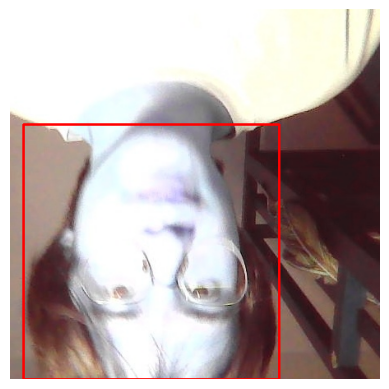

In [11]:
# Plot transformed image with bounding box
from pathlib import Path

def visualizer(img_path):
    image_name = os.path.basename(img_path)
    image = cv2.imread(img_path)
    parent_path = str(Path(img_path).parents[1])
    label_file = f'{image_name.split(".")[0]}.{image_name.split(".")[1]}.json'
    label_path = os.path.join(parent_path, "labels", label_file)
    with open(label_path, "r") as f:
        label = json.load(f)
        
    cv2.rectangle(
        image,
        tuple(np.multiply(label['bbox'][:2], [450, 450]).astype(int)),
        tuple(np.multiply(label['bbox'][2:], [450, 450]).astype(int)),
        (255, 0, 0),
        2,
    )
    plt.imshow(image)
    plt.axis("off")
    
visualizer(train_images[0])

In [12]:
from torch.utils.data import Dataset, DataLoader

class FaceDataset(Dataset):
    def __init__(self,
                 image_paths,
                 transforms=None):
        self.image_paths = image_paths
        self.transforms = transforms
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image_name = os.path.basename(img_path)
        image = cv2.imread(img_path)
        parent_path = str(Path(img_path).parents[1])
        label_file = f'{image_name.split(".")[0]}.{image_name.split(".")[1]}.json'
        label_path = os.path.join(parent_path, "labels", label_file)
        with open(label_path, "r") as f:
            label = json.load(f)
            
        cv2.rectangle(
            image,
            tuple(np.multiply(label['bbox'][:2], [450, 450]).astype(int)),
            tuple(np.multiply(label['bbox'][2:], [450, 450]).astype(int)),
            (255, 0, 0),
            2,
        )

        if self.transforms:
            image = ToTensor()(image)
            image = self.transforms(image)
            
        bbox = torch.tensor(label['bbox']).type(torch.float32)
        target = torch.tensor(label['class']).type(torch.float32)

        return image, (target, bbox)

In [13]:
dataset = FaceDataset(train_images, transforms=image_transform)
image, label = dataset[0]
print(image)
print(label)

tensor([[[1.0000, 1.0000, 1.0000,  ..., 0.7998, 0.9691, 0.9947],
         [1.0000, 1.0000, 1.0000,  ..., 0.8158, 0.9777, 0.9963],
         [1.0000, 1.0000, 1.0000,  ..., 0.8535, 0.9863, 0.9983],
         ...,
         [0.5486, 0.5504, 0.5505,  ..., 0.4445, 0.4496, 0.4618],
         [0.5535, 0.5554, 0.5547,  ..., 0.4528, 0.4541, 0.4613],
         [0.5411, 0.5458, 0.5450,  ..., 0.4617, 0.4628, 0.4628]],

        [[1.0000, 1.0000, 1.0000,  ..., 0.7677, 0.9384, 0.9932],
         [1.0000, 1.0000, 1.0000,  ..., 0.7731, 0.9466, 0.9903],
         [1.0000, 1.0000, 1.0000,  ..., 0.8020, 0.9574, 0.9914],
         ...,
         [0.4662, 0.4635, 0.4621,  ..., 0.3319, 0.3315, 0.3333],
         [0.4631, 0.4537, 0.4474,  ..., 0.3402, 0.3305, 0.3245],
         [0.4561, 0.4501, 0.4430,  ..., 0.3292, 0.3251, 0.3213]],

        [[1.0000, 1.0000, 1.0000,  ..., 0.6912, 0.8344, 0.8555],
         [1.0000, 1.0000, 1.0000,  ..., 0.6909, 0.8370, 0.8567],
         [1.0000, 1.0000, 1.0000,  ..., 0.7068, 0.8318, 0.

In [14]:
dataset_train = FaceDataset(train_images, transforms=image_transform)
dataset_val = FaceDataset(val_images, transforms=image_transform)
dataset_test = FaceDataset(test_images, transforms=image_transform)

In [15]:
print(len(dataset_train))
print(len(dataset_val))
print(len(dataset_test))

3240
1080
1080


In [91]:
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False)

In [93]:
for images, labels in train_loader:
    print(labels[0])
    break

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.])


In [94]:
from torchvision import models

model = models.vgg16(pretrained=True)
model

d:\Coding\face-recognition\.env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Coding\face-recognition\.env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [95]:
# Extract only the features part of the model
model = model.features
model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [96]:
# Freeze the model
for param in model.parameters():
    param.requires_grad = True

In [97]:
import torch
import torch.nn as nn

class FaceModel(nn.Module):
    def __init__(self, model):
        super(FaceModel, self).__init__()
        
        self.vgg = model  # Assume it's VGG16's feature extractor
        
        self.global_max_pool = nn.AdaptiveMaxPool2d(1)  # Output: (batch, 512, 1, 1)
        
        # Classification Head
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1),
        )

        # Regression Head (for bounding box)
        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 2048),
            nn.ReLU(),
            nn.Linear(2048, 4)  # Bounding box coordinates
        )

    def forward(self, x):
        x = self.vgg(x)  # VGG16 backbone
        x = self.global_max_pool(x)  # Global Max Pooling
        x = torch.flatten(x, start_dim=1)  # Ensure shape (batch, 512)
        
        class_output = self.classifier(x)  # Binary classification
        reg_output = self.regressor(x)  # Bounding box regression
        
        return class_output, reg_output


In [98]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [99]:
tracker_model = FaceModel(model)
tracker_model.to(device)

FaceModel(
  (vgg): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [100]:
import torch.optim as optim

pos_weight = torch.tensor([559/2681]).to(device)

optimizer = optim.Adam(tracker_model.parameters(), lr=1e-4, weight_decay=0.0001)
classification_loss = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

In [101]:
localization_loss = nn.SmoothL1Loss()

In [102]:
example = tuple((1, 2))
example[1]

2

In [103]:
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    if y_pred.shape[-1] == 1:  # If shape is (batch_size, 1), squeeze it
        y_pred = torch.sigmoid(y_pred) > 0.5  # Convert logits to binary predictions
        y_pred = y_pred.squeeze()  # Remove extra dimensions

    y_true = y_true.float().view(-1)  # Flatten labels
    y_pred = y_pred.float().view(-1)  # Flatten predictions

    correct = torch.eq(y_pred, y_true).sum().item()
    acc = (correct / y_true.numel()) * 100  # Divide by total number of elements
    return acc

In [104]:
from collections import Counter

#label_counts = Counter(label.item() for _, (label, _) in train_loader.dataset)
#print(label_counts)  # Check class imbalance

In [106]:
import time
from tqdm import tqdm

start_time = time.time()
cost_list = []
num_epochs = 3

for epoch in tqdm(range(num_epochs)):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    running_loss = 0.0
    tracker_model.train()
    
    for images, (labels, bbox) in tqdm(train_loader):
        images, labels, bbox = images.to(device), labels.float().to(device), bbox.to(device)  # Convert labels to float
        
        optimizer.zero_grad()
        
        labels_pred, bbox_pred = tracker_model(images)  # Forward pass
        
        # Compute correct losses
        labels_pred_loss = classification_loss(labels_pred, labels.unsqueeze(1))  # BCE Loss
        bbox_loss = localization_loss(bbox_pred, bbox)  # Regression Loss (Fix Bug Here!)
        
        loss = 0.5 * labels_pred_loss + bbox_loss  # Combine losses
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
        
    running_loss /= len(train_loader)
    cost_list.append(running_loss)
    
    # Validation
    test_loss, test_acc = 0, 0
    tracker_model.eval()
    
    with torch.inference_mode():
        for images, (labels, bbox) in val_loader:
            images, labels, bbox = images.to(device), labels.float().to(device), bbox.to(device)
            
            labels_pred, bbox_pred = tracker_model(images)
            
            labels_pred_loss = classification_loss(labels_pred, labels.unsqueeze(1))
            bbox_loss = localization_loss(bbox_pred, bbox)
            
            test_loss += 0.5 * labels_pred_loss + bbox_loss
            # Convert Sigmoid output to binary class
            test_acc += accuracy_fn(y_pred=labels_pred, y_true=labels)
        
        test_loss /= len(val_loader)
        test_acc /= len(val_loader)
        
        print(f"Train loss: {running_loss:.4f} | Val Loss: {test_loss:.4f} | Val Accuracy: {test_acc:.2f}%")

print(f"Training time: {time.time() - start_time}")


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3


 33%|███▎      | 1/3 [00:32<01:04, 32.03s/it]

Train loss: 0.0003 | Val Loss: 0.0005 | Val Accuracy: 100.00%
Epoch 2/3


 67%|██████▋   | 2/3 [01:03<00:31, 31.88s/it]

Train loss: 0.0003 | Val Loss: 0.0004 | Val Accuracy: 100.00%
Epoch 3/3


100%|██████████| 3/3 [01:35<00:00, 31.81s/it]

Train loss: 0.0002 | Val Loss: 0.0004 | Val Accuracy: 100.00%
Training time: 95.41887426376343


In [ ]:
# Visualize the model's predictions
def visualize_predictions(model, loader, limit=5):
    model.eval()

    for images, (labels, bbox) in loader:
        images, labels, bbox = images.to(device), labels.float().to(device), bbox.to(device)

        labels_pred, bbox_pred = model(images)
        for i in range(images.shape[0]):
            image = images[i].permute(1, 2, 0).cpu().numpy()
            plt.imshow(image)
            
            # Convert Sigmoid output to binary class
            pred_class = torch.sigmoid(labels_pred[i]) > 0.5
            pred_bbox = bbox_pred[i]
            
            # Plot bounding box
            x1, y1, x2, y2 = pred_bbox
            x1, y1, x2, y2 = x1.item(), y1.item(), x2.item(), y2.item()
            plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor="red", lw=2))
            
            plt.title(f"Predicted Class: {pred_class.item()}")
            plt.axis("off")
            plt.show()

visualize_predictions(tracker_model, test_loader)

In [111]:
import cv2

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = transforms.Resize((120, 120))(ToTensor()(rgb))
    # Normalize by dividing by 255
    normalized = resized/255
    
    yhat = tracker_model(normalized.unsqueeze(0).to(device))
    yhat = [x.detach().cpu().numpy() for x in yhat]
    y_preds = torch.sigmoid(torch.tensor(yhat[0]))
    sample_coords = yhat[1][0]
    if y_preds: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

Face Probability: tensor([[0.0252]])
Bounding Box Coordinates: [0.02718541 0.01728433 0.04191951 0.01991332]
Face Probability: tensor([[0.0252]])
Bounding Box Coordinates: [0.02718395 0.01729228 0.04188868 0.0199321 ]
Face Probability: tensor([[0.0252]])
Bounding Box Coordinates: [0.02718395 0.01729228 0.04188868 0.0199321 ]
Face Probability: tensor([[0.0252]])
Bounding Box Coordinates: [0.02718395 0.01729228 0.04188868 0.0199321 ]
Face Probability: tensor([[0.0252]])
Bounding Box Coordinates: [0.02721279 0.01728723 0.0418691  0.01992839]
Face Probability: tensor([[0.0252]])
Bounding Box Coordinates: [0.02721279 0.01728723 0.0418691  0.01992839]
Face Probability: tensor([[0.0251]])
Bounding Box Coordinates: [0.02721624 0.01727504 0.04188851 0.01989669]
Face Probability: tensor([[0.0251]])
Bounding Box Coordinates: [0.02722186 0.01730248 0.04185209 0.01989282]
Face Probability: tensor([[0.0251]])
Bounding Box Coordinates: [0.02722186 0.01730248 0.04185209 0.01989282]
Face Probability: t